<a href="https://colab.research.google.com/github/sumiyaanika/roadway-impairment/blob/main/Hough_cpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def display_image(img, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:
from google.colab import files

# Upload an image from your local drive
uploaded = files.upload()
image_path = next(iter(uploaded))  # Get the image filename


Saving hough1.jpg to hough1.jpg


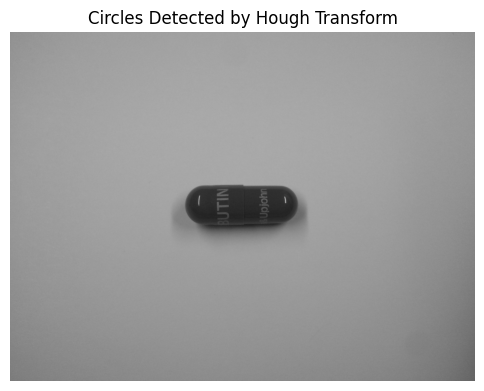

In [ ]:
# Load the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(image, (9, 9), 2)

# Use HoughCircles to detect circles
circles = cv2.HoughCircles(
    blurred_image,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=50,
    param1=200,
    param2=50,
    minRadius=0,
    maxRadius=0
)

# Convert circles to uint16 and display
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])  # Circle center
        radius = circle[2]               # Circle radius
        # Draw the circle center
        cv2.circle(output, center, 1, (0, 255, 0), 3)
        # Draw the circle outline
        cv2.circle(output, center, radius, (0, 0, 255), 3)

# Display the results
display_image(output, "Circles Detected by Hough Transform")


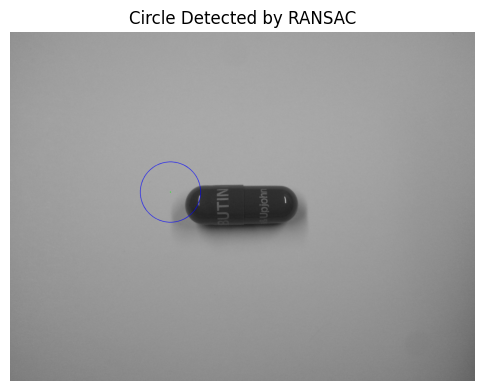

In [ ]:
# Edge detection to get circle candidates
edges = cv2.Canny(blurred_image, 50, 150)

# Find edge points
edge_points = np.column_stack(np.where(edges > 0))

# RANSAC Parameters
iterations = 1000
distance_threshold = 5
best_circle = None
max_inliers = 0

# Function to calculate circle from 3 points
def fit_circle(p1, p2, p3):
    # Circle from 3 points
    temp = p2[0]**2 + p2[1]**2
    bc = (p1[0]**2 + p1[1]**2 - temp) / 2
    cd = (temp - p3[0]**2 - p3[1]**2) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1e-10:  # Points are collinear
        return None, None

    # Calculate circle center
    cx = (bc * (p2[1] - p3[1]) - cd * (p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det
    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return (int(cx), int(cy)), int(radius)

# RANSAC for Circle Detection
for i in range(iterations):
    # Randomly select 3 points
    sample = edge_points[np.random.choice(edge_points.shape[0], 3, replace=False)]
    center, radius = fit_circle(sample[0], sample[1], sample[2])

    if center is None:
        continue

    # Count inliers
    inliers = 0
    for point in edge_points:
        distance = abs(np.sqrt((point[0] - center[1])**2 + (point[1] - center[0])**2) - radius)
        if distance < distance_threshold:
            inliers += 1

    # Update the best circle model if the current one has more inliers
    if inliers > max_inliers:
        max_inliers = inliers
        best_circle = (center, radius)

# Draw the best circle found
ransac_output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
if best_circle is not None:
    cv2.circle(ransac_output, best_circle[0], best_circle[1], (0, 0, 255), 2)
    cv2.circle(ransac_output, best_circle[0], 1, (0, 255, 0), 3)

# Display RANSAC results
display_image(ransac_output, "Circle Detected by RANSAC")
